#Trabalho: semana 9
##Objetivo: Análise de Sentimentos em Tweets em Português utiliziando Transfer Learning
##Dataset: Portuguese Tweets for Sentiment Analysis - https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis

Antes de iniciar, certifique-se que obteve uma maquina com GPU ou TPU

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 21 01:39:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###Verificando memória RAM

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Conectar ao google drive para salvar modelos

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Importar bibliotecas necessárias

In [ ]:
import os
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Dropout, Conv1D, GlobalMaxPooling1D, LSTM, Flatten, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix
import numpy as np
import string
import wordcloud
from matplotlib import pylab as plt
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Seguir os passos descritos aqui https://www.kaggle.com/general/74235

In [ ]:
! pip install -q kaggle
from google.colab import files 
files.upload() #aqui faz o upload do kaggle.json que voce gerou. Ver link acima.

Baixar e extrair o dataset

In [ ]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
if os.path.exists('portuguese-tweets-for-sentiment-analysis.zip') == False:
  !kaggle datasets download -d augustop/portuguese-tweets-for-sentiment-analysis
  !unzip portuguese-tweets-for-sentiment-analysis.zip

Visualizar os dados

In [ ]:
def load_data(file_train = 'trainingdatasets/Train3Classes.csv', file_test = 'testdatasets/Test3classes.csv'):
    train = pd.read_csv(
        file_train, delimiter=';')

    test = pd.read_csv(
        file_test, delimiter=';')
    
    return train, test

train, test = load_data()
train.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


## Padronização para analise dos dados

In [ ]:
#Support functions
def plot_loss_graphs(history):
  plt.figure()
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend(['Loss', 'Val_Loss'])
  plt.figure()
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend(['Accuracy', 'Val_Accuracy'])

#To plot a multiclass confusion matrix more "beautifuly"
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Separar os dados em treino e teste de acordo com a sugestão do autor

In [ ]:
#Divides in train and test
X_train = train.loc[:, 'tweet_text'].values
y_train = train.loc[:, 'sentiment'].values

X_test = test.loc[:, 'tweet_text'].values
y_test = test.loc[:, 'sentiment'].values

print("X_train:", X_train[0])
print("y_train:", y_train[0])
print("X_test:", X_test[0])
print("y_test:", y_test[0])


X_train: @Laranjito76 A pessoa certa para isso seria o vale e azevedo :)
y_train: 1
X_test: @Gazo1a Nossa! Muito obrigada :)
y_test: 1


In [ ]:
y_train_onehot = pd.get_dummies(y_train)
y_test_onehot = pd.get_dummies(y_test)

Pre-processamento.
Sugestões:
- Remover  dos tweets @nomes, #hashtags, links, pontuações, caracteres especiais como ([/*, 
etc..
- Tokenizar os tweets (pode ser usada a biblioteca tensorflow.keras.preprocessing.text.Tokenizer ou algum módulo para tokenização do [nltk](https://www.nltk.org/api/nltk.tokenize.html))
- Fazer preenchimento da sequencia (pad_sequences) com base no tweet de maior tamanho.
- 

In [ ]:
#Preprocessing the tweets
def preprocessingText(X):
  #Removing @, #, links, punctuation, special characters...
  for i, tweet in enumerate(X):
      X[i] = re.sub(r'http\S+', '', X[i]) #Remove links 
      X[i] = re.sub(r'@.*?(?=\s)', '', X[i]) #Removes @names
      X[i] = re.sub(r'#.*?(?=\s)', '', X[i]) #Removes #hashtags
      X[i] = X[i].translate(str.maketrans('', '', string.punctuation)) #Removes punctuation and special characteres --> Maybe keep "."?
  return X

preprocess_train = preprocessingText(X_train)
preprocess_test = preprocessingText(X_test)
preprocess_all = np.concatenate((preprocess_train,preprocess_test))

tokenizer = Tokenizer(lower=True) #It is possbile to filter characters using this, but here it was done separetely
tokenizer.fit_on_texts(preprocess_all)
tokens = tokenizer.texts_to_sequences(preprocess_all)
X_train_pad = pad_sequences(tokens[:100000])
X_test_pad = pad_sequences(tokens[100000:])

In [ ]:
#Checking the shape
print('Shape of X_train_pad: ' + str(X_train_pad.shape))

#Cheking word_index
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Shape of X_train_pad: (100000, 69)
Found 69530 unique tokens


Carregar Word Embedding e criar a matriz de word embeddings com base na lista de tokens

In [ ]:
# if os.path.exists('glove/glove_s300.txt') == False:
#   try:
#     os.makedirs('glove')
#   except:
#     pass
#   !wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s300.zip
#   !unzip -o glove_s300.zip
#   os.rename('glove_s300.txt', 'glove/glove_s300.txt')

if os.path.exists('glove/glove_s300.txt') == False:
  try:
    os.makedirs('glove')
  except:
    pass
  !unzip "/content/gdrive/MyDrive/Mestrado/NLP/glove/glove_s300.zip" -d "/content"
  os.rename('glove_s300.txt', 'glove/glove_s300.txt')

glove_embeddings_index = {}


with io.open('glove/glove_s300.txt', encoding='utf8') as f:
    for line in f:
      values = line.split()
      word = values[0]
      try: 
        coefs = np.asarray(values[1:],dtype='float32')
      except:
        word = values[0] + values[1]
        coefs = np.asarray(values[2:],dtype='float32')

      glove_embeddings_index[word] = coefs

#Building the weight matrix 
embedding_matrix_glove = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector_glove = glove_embeddings_index.get(word)
    if embedding_vector_glove is not None:
        #Words not found in embedding index will be all-zeros
        embedding_matrix_glove[i] = embedding_vector_glove[:300]

print('Found %s word vectors' % len(glove_embeddings_index))

Found 929596 word vectors


In [ ]:
# #FastText
# if os.path.exists('fasttext/cbow_s300.txt') == False:
#   try:
#     os.makedirs('fasttext')
#   except:
#     pass
#   !wget http://143.107.183.175:22980/download.php?file=embeddings/fasttext/cbow_s300.zip
#   !unzip -o cbow_s300.zip
#   os.rename('cbow_s300.txt', 'fasttext/cbow_s300.txt')

if os.path.exists('fasttext/cbow_s300.txt') == False:
  try:
    os.makedirs('fasttext')
  except:
    pass
  !unzip "/content/gdrive/MyDrive/Mestrado/NLP/fasttext/cbow_s300.zip" -d "/content"
  os.rename('cbow_s300.txt', 'fasttext/cbow_s300.txt')

FastText_embeddings_index = {}

with io.open('fasttext/cbow_s300.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try: 
          coefs = np.asarray(values[1:],dtype='float32')
        except:
          word = values[0] + values[1]
          coefs = np.asarray(values[2:],dtype='float32')

        FastText_embeddings_index[word] = coefs

#Building the weight matrix 
embedding_matrix_FastText = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector_FastText = FastText_embeddings_index.get(word)
    if embedding_vector_FastText is not None:
        #Words not found in embedding index will be all-zeros
        embedding_matrix_FastText[i] = embedding_vector_FastText[:300]

print('Found %s word vectors' % len(FastText_embeddings_index))

Found 929597 word vectors


In [ ]:
# #Word2Vec
# if os.path.exists('word2vec/cbow_s300.txt') == False:
#   try:
#     os.makedirs('word2vec')
#   except:
#     pass
#   !wget http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s300.zip
#   !unzip -o cbow_s300.zip
#   os.rename('cbow_s300.txt', 'word2vec/cbow_s300.txt')

if os.path.exists('word2vec/cbow_s300.txt') == False:
  try:
    os.makedirs('word2vec')
  except:
    pass
  !unzip "/content/gdrive/MyDrive/Mestrado/NLP/word2vec/cbow_s300.zip" -d "/content"
  os.rename('cbow_s300.txt', 'word2vec/cbow_s300.txt')

Word2Vec_embeddings_index = {}

with io.open('word2vec/cbow_s300.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try: 
          coefs = np.asarray(values[1:],dtype='float32')
        except:
          word = values[0] + values[1]
          coefs = np.asarray(values[2:],dtype='float32')

        Word2Vec_embeddings_index[word] = coefs

#Building the weight matrix 
embedding_matrix_Word2Vec = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector_Word2Vec = Word2Vec_embeddings_index.get(word)
    if embedding_vector_Word2Vec is not None:
        #Words not found in embedding index will be all-zeros
        embedding_matrix_Word2Vec[i] = embedding_vector_Word2Vec[:300]

print('Found %s word vectors' % len(Word2Vec_embeddings_index))

Archive:  /content/gdrive/MyDrive/Mestrado/NLP/word2vec/cbow_s300.zip
  inflating: /content/cbow_s300.txt  
Found 929596 word vectors


#Aqui começa de fato o modelo. O código abaixo e apenas uma sugestão.

## Foi optado por inicialmente treinar 12 modelos:
#### Modelo01 - LSTM com Dropout para regularização
#### Modelo02 - LSTM com Glove e Dropout para regularização
#### Modelo03 - LSTM com Fasttext e Dropout para regularização
#### Modelo04 - LSTM com Word2Vec e Dropout para regularização
#### Modelo05 - GRU com Dropout para regularização
#### Modelo06 - GRU com Glove e Dropout para regularização
#### Modelo07 - GRU com Fasttext e Dropout para regularização
#### Modelo08 - GRU com Word2Vec e Dropout para regularização
#### Modelo09 - Conv1D com Dropout para regularização
#### Modelo10 - Conv1D com Glove e Dropout para regularização
#### Modelo11 - Conv1D com Fasttext e Dropout para regularização
#### Modelo12 - Conv1D com Word2Vec e Dropout para regularização

## O modelo que apresentar melhor performance, será alterado com o objetivo de atingir melhor precisão.

# Modelo01 - LSTM com Dropout para regularização

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         20859300  
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 21,079,335
Trainable params: 21,079,335
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3125/3125 [==============================] - 32s 9ms/step - loss: 0.5241 - accuracy: 0.7644 - val_loss: 0.4133 - val_accuracy: 0.8126
Epoch 2/10
3125/3125 [=========

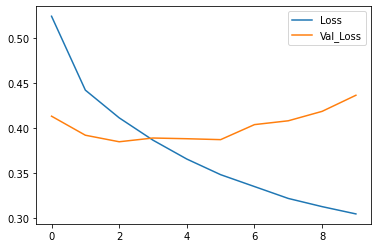

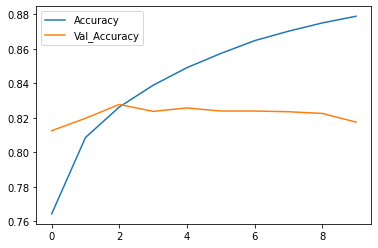

In [ ]:
modelo01=Sequential()
modelo01.add(Embedding(len(word_index)+1, 300))
modelo01.add(Dropout(0.5))
modelo01.add(LSTM(128, dropout=0.5))
modelo01.add(Dense(3, activation='softmax'))
modelo01.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo01.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo01.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_1=modelo01.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_1)


Gerar os resultados. 
A variavel hist pode ser usada para plotar as curvas. Para obter as predicoes, usar model.predict(test_batches).
Matrizes de confusao e metricas podem ser facilmente calculadas usando o pacote 
scikit-learn.


[[1206  429   31]
 [ 321 1300   46]
 [   2   32 1632]]


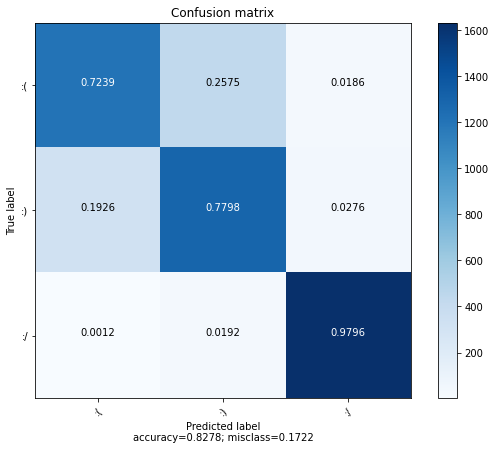

In [ ]:
#Prediction
modelo01 = load_model("/content/gdrive/MyDrive/best_nlp_modelo01.hdf5")
Resultado01 = modelo01.predict(X_test_pad)

new_cf_1 = confusion_matrix(y_test, np.argmax(Resultado01, axis=1))
print(new_cf_1)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_1, target_nm)

#Modelo02 - LSTM com Glove e Dropout para regularização

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         20859300  
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 21,079,335
Trainable params: 220,035
Non-trainable params: 20,859,300
_________________________________________________________________
Epoch 1/10
3125/3125 [==============================] - 23s 7ms/step - loss: 0.5949 - accuracy: 0.7217 - val_loss: 0.4296 - val_accuracy: 0.7932
Epoch 2/10
3125/3125 [=

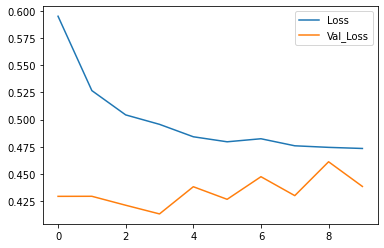

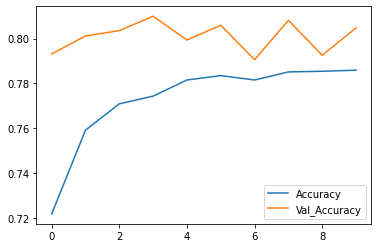

In [ ]:
modelo02=Sequential()
modelo02.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix_glove], trainable=False))
modelo02.add(Dropout(0.5))
modelo02.add(LSTM(128, dropout=0.5))
modelo02.add(Dense(3, activation='softmax'))
modelo02.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo02.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo02.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_2=modelo02.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_2)

[[1301  350   15]
 [ 452 1191   24]
 [  31   78 1557]]


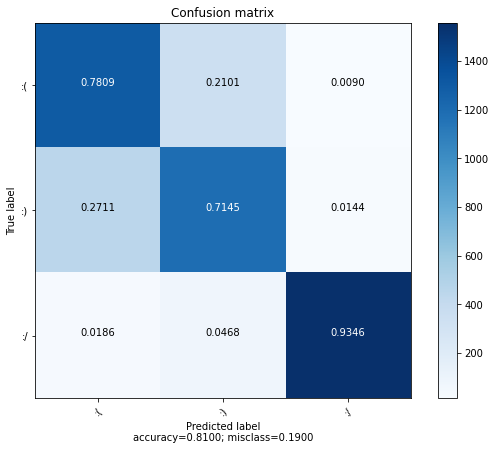

In [ ]:
#Prediction
modelo02 = load_model("/content/gdrive/MyDrive/best_nlp_modelo02.hdf5")
Resultado02 = modelo02.predict(X_test_pad)

new_cf_2 = confusion_matrix(y_test, np.argmax(Resultado02, axis=1))
print(new_cf_2)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_2, target_nm)

# Modelo03 - LSTM com Fasttext e Dropout para regularização

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         20859300  
                                                                 
 dropout_2 (Dropout)         (None, None, 300)         0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 21,079,335
Trainable params: 220,035
Non-trainable params: 20,859,300
_________________________________________________________________
Epoch 1/10
3125/3125 [==============================] - 23s 7ms/step - loss: 0.6437 - accuracy: 0.6945 - val_loss: 0.4588 - val_accuracy: 0.7764
Epoch 2/10
3125/3125 [=

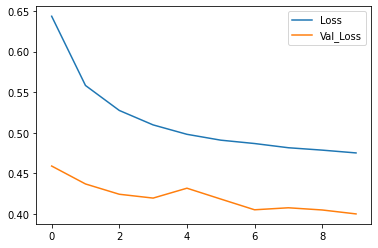

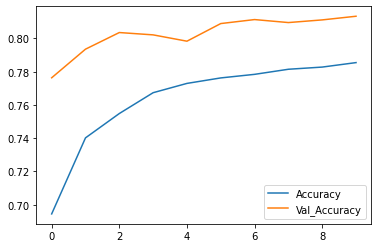

In [ ]:
modelo03=Sequential()
modelo03.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix_FastText], trainable=False))
modelo03.add(Dropout(0.5))
modelo03.add(LSTM(128, dropout=0.5))
modelo03.add(Dense(3, activation='softmax'))
modelo03.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo03.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo03.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_3=modelo03.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_3)

[[1356  289   21]
 [ 508 1107   52]
 [   6   57 1603]]


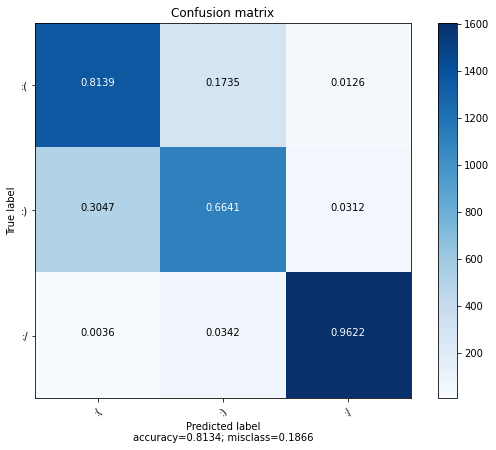

In [ ]:
#Prediction
modelo03 = load_model("/content/gdrive/MyDrive/best_nlp_modelo03.hdf5")
Resultado03 = modelo03.predict(X_test_pad)

new_cf_3 = confusion_matrix(y_test, np.argmax(Resultado03, axis=1))
print(new_cf_3)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_3, target_nm)

# Modelo04 - LSTM com Word2Vec e Dropout para regularização

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         20859300  
                                                                 
 dropout_3 (Dropout)         (None, None, 300)         0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               219648    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 21,079,335
Trainable params: 220,035
Non-trainable params: 20,859,300
_________________________________________________________________
Epoch 1/10
3125/3125 [==============================] - 23s 7ms/step - loss: 0.6456 - accuracy: 0.6939 - val_loss: 0.4755 - val_accuracy: 0.7748
Epoch 2/10
3125/3125 [=

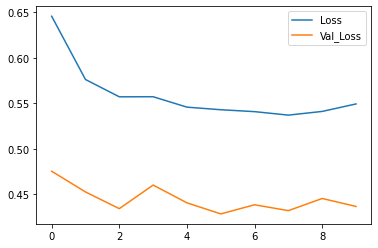

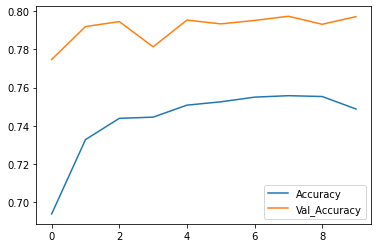

In [ ]:
modelo04 = Sequential()
modelo04.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix_Word2Vec], trainable=False))
modelo04.add(Dropout(0.5))
modelo04.add(LSTM(128, dropout=0.5))
modelo04.add(Dense(3, activation='softmax'))
modelo04.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo04.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo04.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_4=modelo04.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_4)

[[1356  287   23]
 [ 557 1044   66]
 [   6   74 1586]]


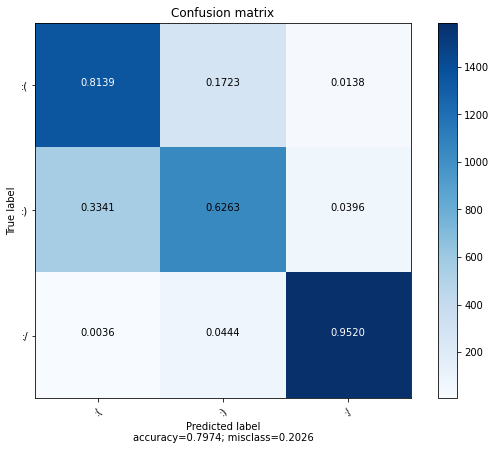

In [ ]:
#Prediction
modelo04 = load_model("/content/gdrive/MyDrive/best_nlp_modelo04.hdf5")
Resultado04 = modelo04.predict(X_test_pad)

new_cf_4 = confusion_matrix(y_test, np.argmax(Resultado04, axis=1))
print(new_cf_4)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_4, target_nm)

# Modelo05 - GRU com Dropout para regularização

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 300)         20859300  
                                                                 
 dropout_5 (Dropout)         (None, None, 300)         0         
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 21,024,807
Trainable params: 21,024,807
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3125/3125 [==============================] - 27s 8ms/step - loss: 0.5211 - accuracy: 0.7659 - val_loss: 0.4097 - val_accuracy: 0.8178
Epoch 2/10
3125/3125 [=======

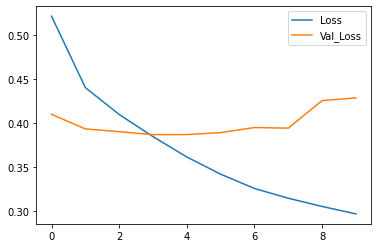

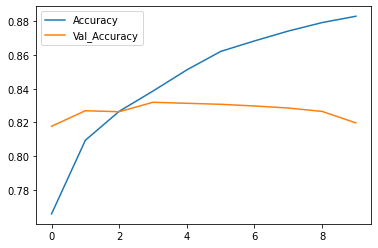

In [ ]:
modelo05=Sequential()
modelo05.add(Embedding(len(word_index)+1, 300))
modelo05.add(Dropout(0.5))
modelo05.add(GRU(128, dropout=0.5))
modelo05.add(Dense(3, activation='softmax'))
modelo05.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo05.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo05.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_5=modelo05.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_5)

[[1233  414   19]
 [ 334 1300   33]
 [   4   36 1626]]


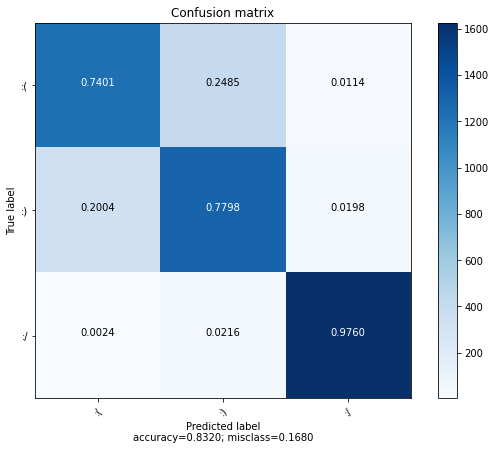

In [ ]:
#Prediction
modelo05 = load_model("/content/gdrive/MyDrive/best_nlp_modelo05.hdf5")
Resultado05 = modelo05.predict(X_test_pad)

new_cf_5 = confusion_matrix(y_test, np.argmax(Resultado05, axis=1))
print(new_cf_5)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_5, target_nm)

# Modelo06 - GRU com Glove e Dropout para regularização

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 300)         20859300  
                                                                 
 dropout_6 (Dropout)         (None, None, 300)         0         
                                                                 
 gru_1 (GRU)                 (None, 128)               165120    
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 21,024,807
Trainable params: 165,507
Non-trainable params: 20,859,300
_________________________________________________________________
Epoch 1/10
3125/3125 [==============================] - 22s 6ms/step - loss: 0.6029 - accuracy: 0.7186 - val_loss: 0.4628 - val_accuracy: 0.7852
Epoch 2/10
3125/3125 [=

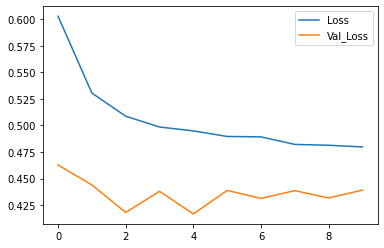

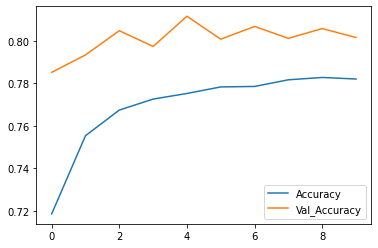

In [ ]:
modelo06=Sequential()
modelo06.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix_glove], trainable=False))
modelo06.add(Dropout(0.5))
modelo06.add(GRU(128, dropout=0.5))
modelo06.add(Dense(3, activation='softmax'))
modelo06.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo06.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo06.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_6=modelo06.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_6)

[[1350  296   20]
 [ 504 1128   35]
 [  19   68 1579]]


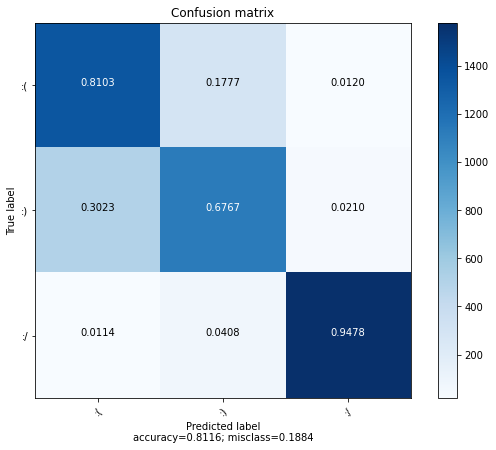

In [ ]:
#Prediction
modelo06 = load_model("/content/gdrive/MyDrive/best_nlp_modelo06.hdf5")
Resultado06 = modelo06.predict(X_test_pad)

new_cf_6 = confusion_matrix(y_test, np.argmax(Resultado06, axis=1))
print(new_cf_6)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_6, target_nm)

# Modelo07 - GRU com Fasttext e Dropout para regularização

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 300)         20859300  
                                                                 
 dropout_7 (Dropout)         (None, None, 300)         0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               219648    
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 21,079,335
Trainable params: 220,035
Non-trainable params: 20,859,300
_________________________________________________________________
Epoch 1/10
3125/3125 [==============================] - 23s 7ms/step - loss: 0.6432 - accuracy: 0.6941 - val_loss: 0.4626 - val_accuracy: 0.7714
Epoch 2/10
3125/3125 [=

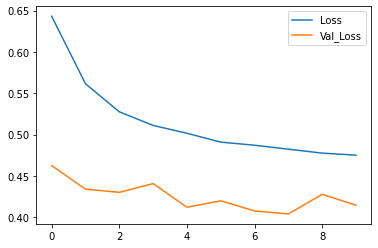

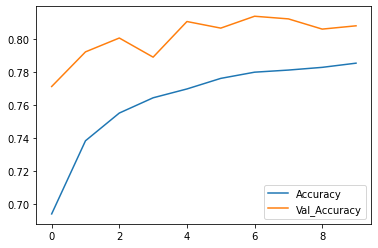

In [ ]:
modelo07=Sequential()
modelo07.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix_FastText], trainable=False))
modelo07.add(Dropout(0.5))
modelo07.add(LSTM(128, dropout=0.5))
modelo07.add(Dense(3, activation='softmax'))
modelo07.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo07.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo07.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_7=modelo07.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_7)

[[1343  302   21]
 [ 490 1139   38]
 [  14   65 1587]]


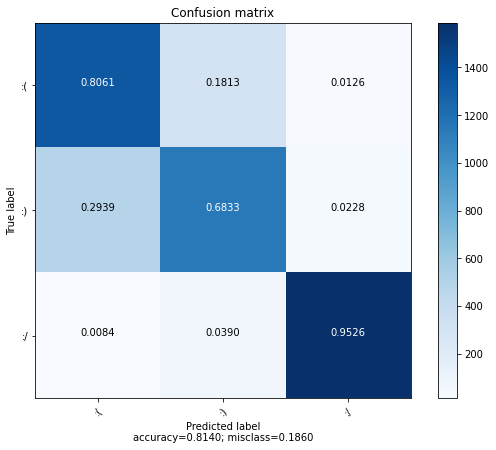

In [ ]:
#Prediction
modelo07 = load_model("/content/gdrive/MyDrive/best_nlp_modelo07.hdf5")
Resultado07 = modelo07.predict(X_test_pad)

new_cf_7 = confusion_matrix(y_test, np.argmax(Resultado07, axis=1))
print(new_cf_7)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_7, target_nm)

# Modelo08 - GRU com Word2Vec e Dropout para regularização

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 300)         20859300  
                                                                 
 dropout_8 (Dropout)         (None, None, 300)         0         
                                                                 
 gru_2 (GRU)                 (None, 128)               165120    
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 21,024,807
Trainable params: 165,507
Non-trainable params: 20,859,300
_________________________________________________________________
Epoch 1/10
3125/3125 [==============================] - 21s 6ms/step - loss: 0.6822 - accuracy: 0.6776 - val_loss: 0.4833 - val_accuracy: 0.7620
Epoch 2/10
3125/3125 [

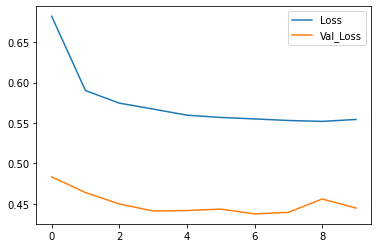

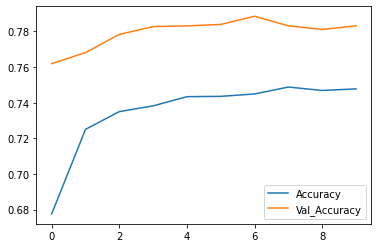

In [ ]:
modelo08=Sequential()
modelo08.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix_Word2Vec], trainable=False))
modelo08.add(Dropout(0.5))
modelo08.add(GRU(128, dropout=0.5))
modelo08.add(Dense(3, activation='softmax'))
modelo08.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo08.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo08.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_8=modelo08.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_8)

[[1380  255   31]
 [ 648  970   49]
 [   8   66 1592]]


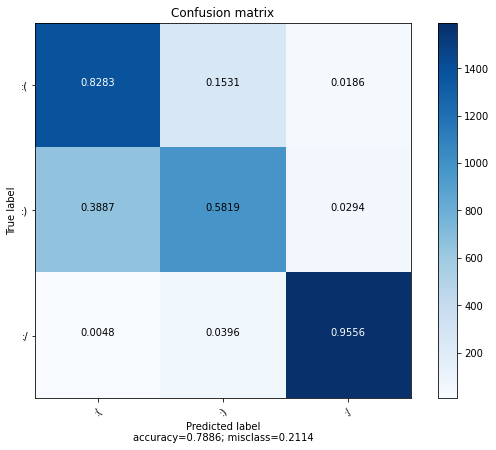

In [ ]:
#Prediction
modelo08 = load_model("/content/gdrive/MyDrive/best_nlp_modelo08.hdf5")
Resultado08 = modelo08.predict(X_test_pad)

new_cf_8 = confusion_matrix(y_test, np.argmax(Resultado08, axis=1))
print(new_cf_8)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_8, target_nm)

# Modelo09 - Conv1D com Dropout para regularização

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 300)         20859300  
                                                                 
 dropout_10 (Dropout)        (None, None, 300)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 dropout_11 (Dropout)        (None, None, 128)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                     

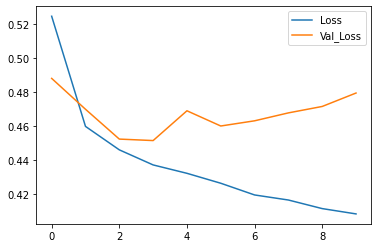

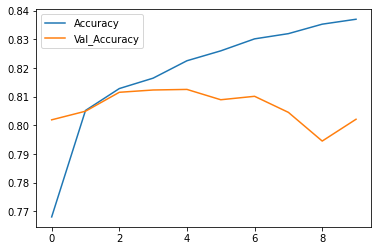

In [ ]:
modelo09=Sequential()
modelo09.add(Embedding(len(word_index)+1, 300))
modelo09.add(Dropout(0.5))
modelo09.add(Conv1D(128, 5))
modelo09.add(Dropout(0.5))
modelo09.add(GlobalMaxPooling1D())
modelo09.add(Dense(3, activation='softmax'))
modelo09.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo09.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo09.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_9=modelo09.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_9)

[[1235  384   47]
 [ 367 1246   54]
 [   6   79 1581]]


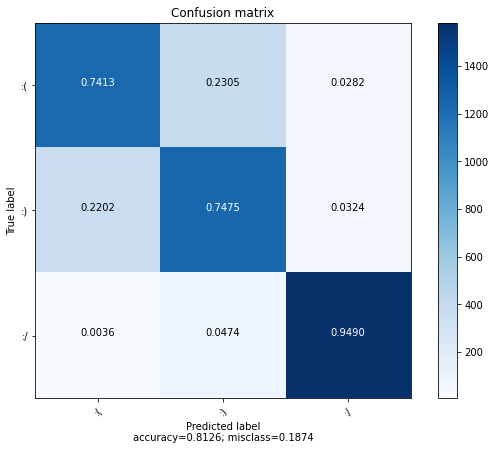

In [ ]:
#Prediction
modelo09 = load_model("/content/gdrive/MyDrive/best_nlp_modelo09.hdf5")
Resultado09 = modelo09.predict(X_test_pad)

new_cf_9 = confusion_matrix(y_test, np.argmax(Resultado09, axis=1))
print(new_cf_9)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_9, target_nm)

# Modelo10 - Conv1D com Glove e Dropout para regularização

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 300)         20859300  
                                                                 
 dropout_12 (Dropout)        (None, None, 300)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         192128    
                                                                 
 dropout_13 (Dropout)        (None, None, 128)         0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                     

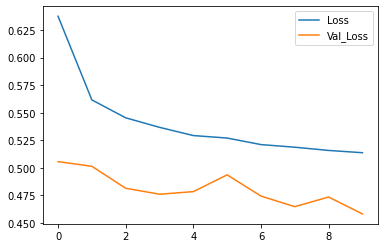

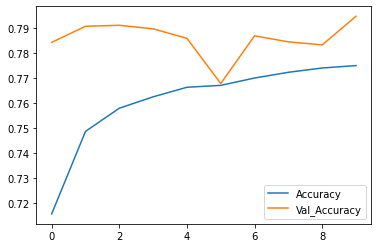

In [ ]:
modelo10=Sequential()
modelo10.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix_glove], trainable=False))
modelo10.add(Dropout(0.5))
modelo10.add(Conv1D(128, 5))
modelo10.add(Dropout(0.5))
modelo10.add(GlobalMaxPooling1D())
modelo10.add(Dense(3, activation='softmax'))
modelo10.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo10.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo10.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_10=modelo10.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_10)

[[1423  231   12]
 [ 620 1025   22]
 [  67   75 1524]]


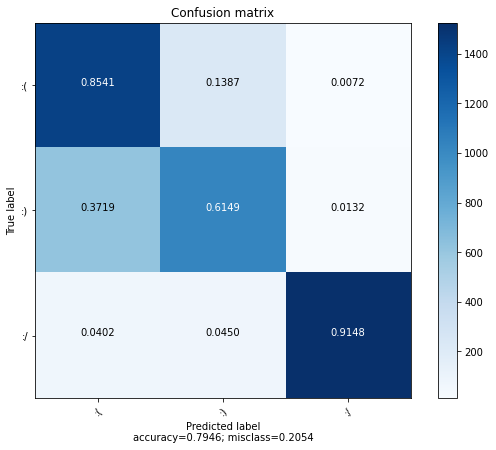

In [ ]:
#Prediction
modelo10 = load_model("/content/gdrive/MyDrive/best_nlp_modelo10.hdf5")
Resultado10 = modelo10.predict(X_test_pad)

new_cf_10 = confusion_matrix(y_test, np.argmax(Resultado10, axis=1))
print(new_cf_10)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_10, target_nm)

# Modelo11 - Conv1D com Fasttext e Dropout para regularização

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 300)         20859300  
                                                                 
 dropout_14 (Dropout)        (None, None, 300)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         192128    
                                                                 
 dropout_15 (Dropout)        (None, None, 128)         0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 3)                 387       
                                                     

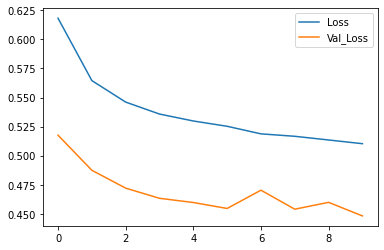

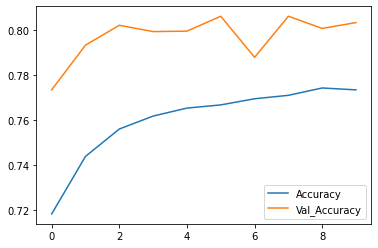

In [ ]:
modelo11=Sequential()
modelo11.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix_FastText], trainable=False))
modelo11.add(Dropout(0.5))
modelo11.add(Conv1D(128, 5))
modelo11.add(Dropout(0.5))
modelo11.add(GlobalMaxPooling1D())
modelo11.add(Dense(3, activation='softmax'))
modelo11.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo11.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo11.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_11=modelo11.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_11)

[[1260  355   51]
 [ 457 1145   65]
 [   3   39 1624]]


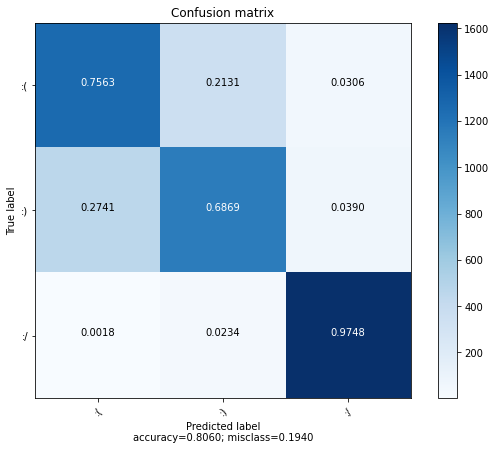

In [ ]:
#Prediction
modelo11 = load_model("/content/gdrive/MyDrive/best_nlp_modelo11.hdf5")
Resultado11 = modelo11.predict(X_test_pad)

new_cf_11 = confusion_matrix(y_test, np.argmax(Resultado11, axis=1))
print(new_cf_11)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_11, target_nm)

# Modelo12 - Conv1D com Word2Vec e Dropout para regularização

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 300)         20859300  
                                                                 
 dropout_16 (Dropout)        (None, None, 300)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         192128    
                                                                 
 dropout_17 (Dropout)        (None, None, 128)         0         
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                     

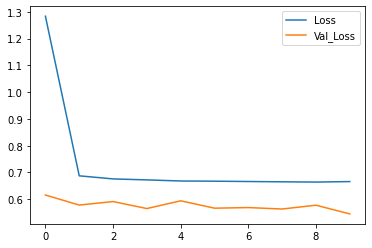

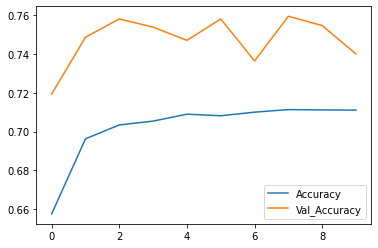

In [ ]:
modelo12=Sequential()
modelo12.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix_Word2Vec], trainable=False))
modelo12.add(Dropout(0.5))
modelo12.add(Conv1D(128, 5))
modelo12.add(Dropout(0.5))
modelo12.add(GlobalMaxPooling1D())
modelo12.add(Dense(3, activation='softmax'))
modelo12.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo12.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo12.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_12=modelo12.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=10,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_12)

[[1246  398   22]
 [ 568 1065   34]
 [  33  148 1485]]


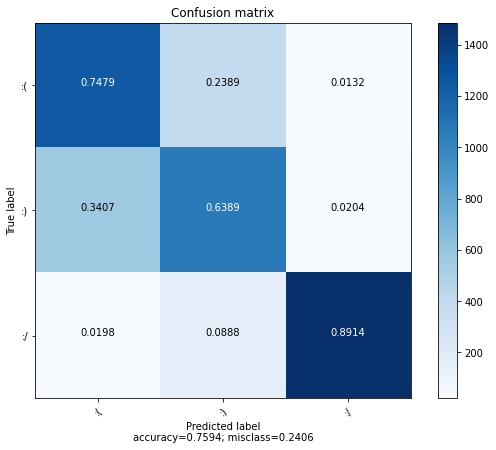

In [ ]:
#Prediction
modelo12 = load_model("/content/gdrive/MyDrive/best_nlp_modelo12.hdf5")
Resultado12 = modelo12.predict(X_test_pad)

new_cf_12 = confusion_matrix(y_test, np.argmax(Resultado12, axis=1))
print(new_cf_12)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_12, target_nm)

#Trabalhando no melhor modelo: Modelo05

###1 - Aumentar o número de epocas de 10 para 30
###2 - Aumentar a quantidade de Dropout
###3 - Adcionando camadas densas relu

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, None, 300)         20859300  
                                                                 
 dropout_87 (Dropout)        (None, None, 300)         0         
                                                                 
 gru_35 (GRU)                (None, 32)                32064     
                                                                 
 dense_83 (Dense)            (None, 512)               16896     
                                                                 
 dropout_88 (Dropout)        (None, 512)               0         
                                                                 
 dense_84 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 20,909,799
Trainable params: 20,909,799

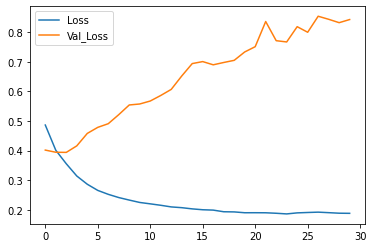

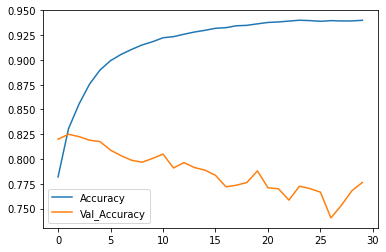

In [ ]:
modelo13=Sequential()
modelo13.add(Embedding(len(word_index)+1, 300))
modelo13.add(Dropout(0.2))

modelo13.add(GRU(32, dropout=0.2))

modelo13.add(Dense(512, activation='relu'))
modelo13.add(Dropout(0.2))

modelo13.add(Dense(3, activation='softmax'))
modelo13.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
modelo13.summary()

nlp_best = ModelCheckpoint('/content/gdrive/MyDrive/best_nlp_modelo13.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
hist_13=modelo13.fit(
    x=X_train_pad,
    y=y_train_onehot,
    batch_size=32,
    epochs=30,
    validation_data = (X_test_pad, y_test_onehot), 
    callbacks=[nlp_best],
    shuffle=True
    )

#Apresenta os gráficos
plot_loss_graphs(hist_13)

[[1351  291   24]
 [ 476 1150   41]
 [   8   35 1623]]


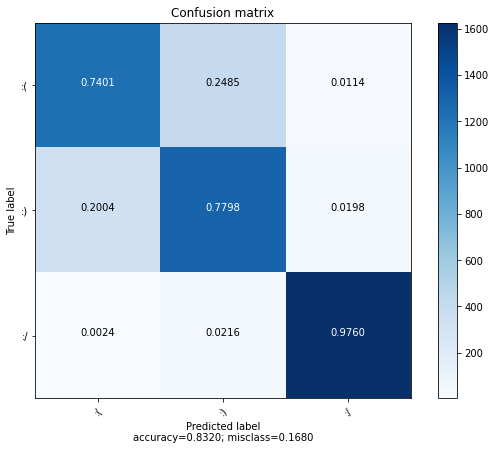

In [ ]:
#Prediction
modelo13 = load_model("/content/gdrive/MyDrive/best_nlp_modelo13.hdf5")
Resultado13 = modelo13.predict(X_test_pad)

new_cf_13 = confusion_matrix(y_test, np.argmax(Resultado13, axis=1))
print(new_cf_13)
target_nm = [':(', ':)', ':/']
plot_confusion_matrix(new_cf_5, target_nm)